# Logistic regression with stochastic gradient descent

The aim of this code is to show how to apply the logistic regression with stochastc gredient descent using tensorflow and other common python libraries. The first cell is about data pre processing an you can find it in detail in other notebooks.

In [1]:
# First import libraries. We arge going to import pandas for data pre procesing, numpy for managing arrays, 
# matplotlib for ploting and tensorflow for our machine learning models.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


df = pd.read_csv("data/train.csv")

print("INFO ABOUT OUR DATA FRAME \n")

print(df.info())
print("\n")

# Drop the columns "Name", "Ticket" and "Cabin"
df2 = df.drop("Name",axis = 1).drop("Ticket",axis = 1).drop("Cabin",axis = 1).drop("PassengerId",axis = 1)

print("VISUALIZE HEAD OF THE DATA FRAME WITH THE NEW DUMMY VARIABLES \n")
print(df2.head())
print("\n")

# Imput Integer number "male":0 and "female":1
df2["Sex"] = df2["Sex"].replace(["male"], 0)
df2["Sex"] = df2["Sex"].replace(["female"], 1)

# Trtansform Embarked in three dummy variables: Embarked_C  Embarked_Q  Embarked_S 
df3 = pd.get_dummies(df2)
# Only 2 of the 3 dummy variables are needed, so we will remove one of them
df3 = df3.drop("Embarked_S",axis = 1)


print("VISUALIZE HEAD OF THE DATA FRAME WITH THE NEW DUMMY VARIABLES \n")
print(df3.head())
print("\n \n")

from sklearn.preprocessing import Imputer

X = df3.drop("Survived",axis = 1).values
y = df3["Survived"].values

# Replace missing values with the mean of each column
imp = Imputer(missing_values = "NaN", 
             strategy = "mean",
             axis = 0) # axis = 0 correspond to the comlumns
imp.fit(X)
X = imp.transform(X)


# Use the scale sklearn.preprocessing function to set all columns at the same scale. 
# This is specially important for the gradient descend
from sklearn.preprocessing import scale
X = scale(X)

# Use train_test_split from sklearn.model_selection to split the features and the target in tain and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

print("THE SHAPE OF THE FEATURES (X) TRAIN SET IS")
print(X_train.shape)
print("\n")
print("THE SHAPE OF THE TARGET (y) TRAIN SET IS")
print(y_train.shape)
print("\n")


INFO ABOUT OUR DATA FRAME 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


VISUALIZE HEAD OF THE DATA FRAME WITH THE NEW DUMMY VARIABLES 

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.

## Model


In [2]:
# Define Graph

nb_classes = 2  # 0 ~ 1

# Create the feature 
x_tf_train = tf.placeholder(shape=[None, 8], dtype=tf.float32)
y_tf_train = tf.placeholder(shape=[None, 1], dtype=tf.int32)

Y_one_hot = tf.one_hot(y_tf_train, nb_classes)  # one hot
print("one_hot", Y_one_hot)
Y_one_hot = tf.reshape(Y_one_hot, [-1, nb_classes])
print("reshape", Y_one_hot)


# Create a Weight tensor W and the bias tensor b
W = tf.Variable(tf.random_normal([8, nb_classes]), name='weight')
b = tf.Variable(tf.random_normal([nb_classes]), name='bias')

# tf.nn.softmax computes softmax activations
# softmax = exp(logits) / reduce_sum(exp(logits), dim)
logits = tf.matmul(x_tf_train, W) + b
hypothesis = tf.nn.softmax(logits)

cost_i = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                 labels=Y_one_hot)

loss = tf.reduce_mean(cost_i)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)

prediction = tf.argmax(hypothesis, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

batch_size = 50

('one_hot', <tf.Tensor 'one_hot:0' shape=(?, 1, 2) dtype=float32>)
('reshape', <tf.Tensor 'Reshape:0' shape=(?, 2) dtype=float32>)


In [3]:

#Train Model
loss_vec = []
acc_vec_train = []
acc_vec_test = []
with tf.Session() as sess:
    # Initialize variables
    init = tf.global_variables_initializer()
    sess.run(init)
    losses = []
    for i in range(3000):
        rand_index = np.random.choice(len(X_train), size=batch_size)
        x_batch = X_train[rand_index]
        y_batch = np.transpose([y_train[rand_index]])
        # Run the session, this is actually what fits the model
        sess.run(optimizer, feed_dict={x_tf_train: x_batch, y_tf_train: y_batch})
        
        temp_loss, acc_train = sess.run([loss, accuracy], feed_dict={
                                 x_tf_train: x_batch, y_tf_train: y_batch})
        acc_test = sess.run(accuracy, feed_dict={
                                 x_tf_train: X_test, y_tf_train: np.transpose([y_test])})
        
        loss_vec.append(temp_loss)
      
        acc_vec_train.append(acc_train)
        acc_vec_test.append(acc_test)
        if i % 400 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(
                i, temp_loss, acc_train))
        

Step:     0	Loss: 2.574	Acc: 38.00%
Step:   400	Loss: 0.806	Acc: 84.00%
Step:   800	Loss: 0.637	Acc: 76.00%
Step:  1200	Loss: 0.507	Acc: 76.00%
Step:  1600	Loss: 0.513	Acc: 74.00%
Step:  2000	Loss: 0.439	Acc: 82.00%
Step:  2400	Loss: 0.418	Acc: 80.00%
Step:  2800	Loss: 0.567	Acc: 70.00%


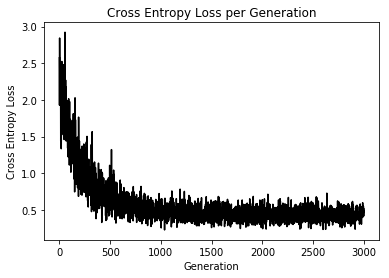

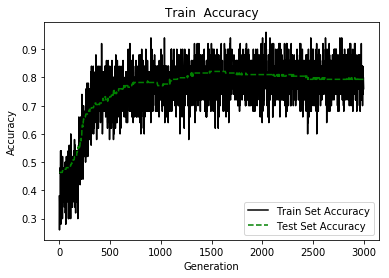

In [4]:
# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Plot train and test accuracy
plt.plot(acc_vec_train, 'k-', label='Train Set Accuracy')
plt.plot(acc_vec_test, 'g--', label='Test Set Accuracy')
#plt.plot(acc_vec, 'k-')
plt.title('Train  Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()